In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        VD = torch.zeros(V.shape[0], V.shape[1], 2).to(self.device)
        VD[:,:,0] = VD[:,:,0] + V
        VD[:,:,1] = VD[:,:,1] + D
        
        rnn_out, _ = self.rnn(VD) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [3]:
batch_size = 20
batch_length = 50000
H_no = 20
device = torch.device("cuda")

epoch_no = 200
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
D = V.copy()
#D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"]
#D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["test"]
#D_train = torch.from_numpy(D_train).float()
#D_test = torch.from_numpy(D_test).float().to(device)

D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
D_train = D[:980].float()
D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_GRU(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

1461


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V, batch_D)
    loss = torch.mean((S_out - batch_S)**2)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-c0b0dca94fca>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/9800 [00:00<?, ?it/s]

0 0.00488734245300293 0.8344376087188721
49 0.02318507432937622 1.0842113494873047
99 0.029712140560150146 1.0762791633605957
149 0.039617955684661865 1.0793986320495605
199 0.021368741989135742 1.084082841873169
249 0.03876841068267822 1.0653927326202393
299 0.05592846870422363 1.0761702060699463
349 0.09958076477050781 1.0856680870056152
399 0.08337664604187012 1.0993337631225586
449 0.12080436944961548 1.0718169212341309
499 0.13458532094955444 1.092710018157959
549 0.15692144632339478 1.0808403491973877
599 0.13540130853652954 1.0852491855621338
649 0.1595962643623352 1.0699126720428467
699 0.07350367307662964 1.0933232307434082
749 0.1489294171333313 1.09385085105896
799 0.16058087348937988 1.0877552032470703
849 0.001072704792022705 1.0905330181121826
899 0.03274071216583252 1.0730726718902588
949 0.06247907876968384 1.0737524032592773
999 0.10419666767120361 1.1002674102783203
1049 0.131908118724823 1.092698574066162
1099 0.15763449668884277 1.0952541828155518
1149 0.13847243785

9499 0.28501009941101074 1.0838584899902344
9549 0.2908037304878235 1.075988531112671
9599 0.2936263084411621 1.091705560684204
9649 0.2992287874221802 1.0786092281341553
9699 0.28506457805633545 1.088179111480713
9749 0.22918611764907837 1.0789616107940674
9799 0.2791065573692322 0.8078770637512207


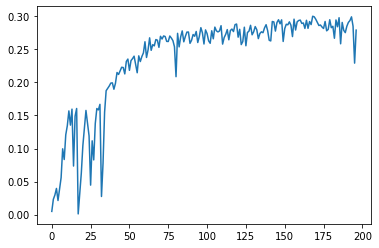

In [7]:
plt.plot(np.asarray(score_list))

(-1.0, 10.0)

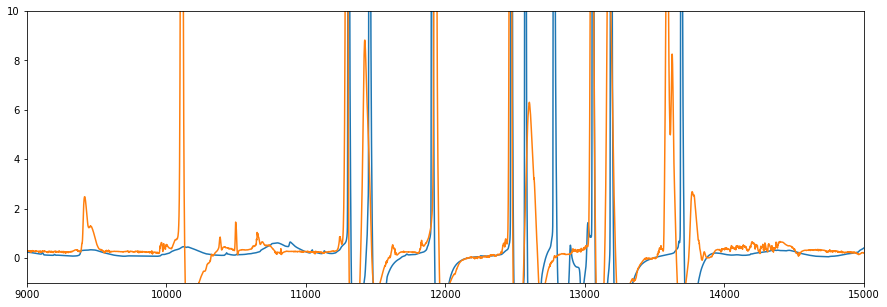

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(9000,15000)
plt.ylim(-1,10)

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_h20.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_h20_test.npy", test_S_out.cpu().detach().numpy())